In [2]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm

batch=32
data_path = r"C:\Datasets\Engagement"  # Provide your data path here

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()
validate_epochs = 1  # Example: validate every epoch
save_epochs = 2     # Example: save the model every 2 epochs
ckpt_dir = r"C:\Datasets\Engagement\checkpoints"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally
    #transforms.RandomVerticalFlip(p=0.5),  # Randomly flip the image vertically
    #transforms.RandomRotation(degrees=15),  # Randomly rotate the image by up to 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly change the brightness, contrast, saturation, and hue
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random translation
    #transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.75, 1.33)),  # Randomly crop and resize the image
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform3 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


transform2 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
class GazeDataset(Dataset):
    def __init__(self, csv_file, data_path, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file.
            data_path (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.data_path = data_path
        self.transform = transform
        # Create a dictionary mapping each unique gaze value to a unique integer
        self.gaze_to_int ={3: 0, 2: 1, 1: 0, 4: 1}
        self.num_classes = 2
    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_path+"\image_original", self.data_frame['imgID'][idx])  # Assuming imgID is in the first column
        image = Image.open(img_name)
        dep_name = os.path.join(self.data_path+"\depth_intermediate", self.data_frame['imgID'][idx])
        depth = Image.open(dep_name)
        gaze_name = os.path.join(self.data_path+"\predict_heatmap", self.data_frame['imgID'][idx])
        gaze_img = Image.open(gaze_name)
        teacher_name = os.path.join(self.data_path+"\\teachernpy", self.data_frame['imgID'][idx][:-3]+"npy")
        teacherdata = np.load(teacher_name)
        student_name=os.path.join(self.data_path+"\\studentnpy", self.data_frame['imgID'][idx][:-3]+"npy")
        studentdata = np.load(student_name)
        if self.transform:
            image = self.transform(image)
            depth = transform2(depth)
            gaze_img = transform2(gaze_img)
            studentdata = transform2(Image.fromarray(studentdata))
            teacherdata = transform2(Image.fromarray(teacherdata))
            
        gaze = self.data_frame['gaze'][idx]   # Assuming gaze is in the second column
        gaze_idx = self.gaze_to_int[gaze]

        # Convert gaze_idx to one-hot encoded vector
        one_hot_gaze = torch.zeros(self.num_classes)
        one_hot_gaze[gaze_idx] = 1
        return image, depth,gaze_img, one_hot_gaze,teacherdata,studentdata

# Create datasets
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming that your CSV file has two columns: 'imgID' for image file names and 'gaze' for gaze labels
data_frame = pd.read_csv('C:\Datasets\labels_and_features_TRAIN.csv')


train_dataset = GazeDataset(csv_file='C:\Datasets\labels_and_features_TRAIN.csv', data_path=data_path, transform=transform)
valid_dataset = GazeDataset(csv_file='C:\Datasets\labels_and_features_VAL.csv', data_path=data_path, transform=transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=batch, shuffle=False, num_workers=0)

# Load a pre-trained ResNet-18 model and modify the final layer
model = models.resnet18(weights="ResNet18_Weights.DEFAULT")
model.fc = nn.Linear(model.fc.in_features, 2)
model.conv1 = nn.Conv2d(9, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

#model=model2
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.00001)
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)
import os
import torch
from tqdm import tqdm

# Training loop
num_epochs = 10  # Define your desired number of epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    print("start epoch :"+str(epoch))
    # Add a progress bar for the training loop

    for images,depth, gaze, gazes,teacherdata,studentdata in tqdm(train_loader): # train_progress_bar:

        inputs = torch.cat([images, depth, gaze,teacherdata,studentdata], dim=1)
        # print(inputs.shape)
        inputs, gazes = inputs.to(device), torch.argmax(gazes, dim=1).to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, gazes)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        # Update the progress bar


    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")

    # Save checkpoint
    if (epoch + 1) % save_epochs == 0:
        torch.save(model.state_dict(), os.path.join(ckpt_dir, f"epoch_{epoch+1}.ckpt"))

    # Validation loop
    if (epoch + 1) % validate_epochs == 0:
        model.eval()
        correct = 0
        total = 0
        # Add a progress bar for the validation loop
        valid_progress_bar = tqdm(valid_loader, desc='Validating', leave=False)
        with torch.no_grad():
            for images, depth, gaze, gazes,teacherdata,studentdata in valid_progress_bar:
                inputs = torch.cat([images, depth, gaze,teacherdata,studentdata], dim=1)
                inputs, gazes = inputs.to(device), torch.argmax(gazes, dim=1).to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += gazes.size(0)
                correct += (predicted == gazes).sum().item()

        print(f"Validation Accuracy: {100 * correct / total}%")

print("Training completed.")




start epoch :0


 81%|██████████████████████████████████████████████████████████████████                | 62/77 [02:13<00:32,  2.15s/it]


KeyboardInterrupt: 

In [47]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm

batch=32
data_path = r"C:\Datasets\Engagement"  # Provide your data path here

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()
validate_epochs = 1  # Example: validate every epoch
save_epochs = 2     # Example: save the model every 2 epochs
ckpt_dir = r"C:\Datasets\Engagement\checkpoints"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally
    #transforms.RandomVerticalFlip(p=0.5),  # Randomly flip the image vertically
    #transforms.RandomRotation(degrees=15),  # Randomly rotate the image by up to 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly change the brightness, contrast, saturation, and hue
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random translation
    #transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.75, 1.33)),  # Randomly crop and resize the image
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform3 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


transform2 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
class GazeDataset(Dataset):
    def __init__(self, csv_file, data_path, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file.
            data_path (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.data_path = data_path
        self.transform = transform
        # Create a dictionary mapping each unique gaze value to a unique integer
        self.gaze_to_int ={3: 0, 2: 1, 1: 0, 4: 1}
        self.num_classes = 2
    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_path+"\image_original", self.data_frame['imgID'][idx])  # Assuming imgID is in the first column
        image = Image.open(img_name)
        head_name = os.path.join(self.data_path+"\predict_head", self.data_frame['imgID'][idx])
        head = Image.open(head_name)
        gaze_name = os.path.join(self.data_path+"\predict_heatmap", self.data_frame['imgID'][idx])
        gaze_img = Image.open(gaze_name)
        teacher_name = os.path.join(self.data_path+"\\teachernpy", self.data_frame['imgID'][idx][:-3]+"npy")
        teacherdata = np.load(teacher_name)
        student_name=os.path.join(self.data_path+"\\studentnpy", self.data_frame['imgID'][idx][:-3]+"npy")
        studentdata = np.load(student_name)
        if self.transform:
            image = self.transform(image)
            head = transform2(head)
            gaze_img = transform2(gaze_img)
            studentdata = transform2(Image.fromarray(studentdata))
            teacherdata = transform2(Image.fromarray(teacherdata))
            
        gaze = self.data_frame['gaze'][idx]   # Assuming gaze is in the second column
        gaze_idx = self.gaze_to_int[gaze]

        # Convert gaze_idx to one-hot encoded vector
        one_hot_gaze = torch.zeros(self.num_classes)
        one_hot_gaze[gaze_idx] = 1
        return image, head,gaze_img, one_hot_gaze,teacherdata,studentdata

# Create datasets
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming that your CSV file has two columns: 'imgID' for image file names and 'gaze' for gaze labels
data_frame = pd.read_csv('C:\Datasets\labels_and_features_TRAIN.csv')


train_dataset = GazeDataset(csv_file='C:\Datasets\labels_and_features_TRAIN.csv', data_path=data_path, transform=transform)
valid_dataset = GazeDataset(csv_file='C:\Datasets\labels_and_features_VAL.csv', data_path=data_path, transform=transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=batch, shuffle=False, num_workers=0)

# Load a pre-trained ResNet-18 model and modify the final layer
model = models.resnet18(weights="ResNet18_Weights.DEFAULT")
model.fc = nn.Linear(model.fc.in_features, 2)
model.conv1 = nn.Conv2d(9, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

#model=model2
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.00001)
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)
import os
import torch
from tqdm import tqdm

# Training loop
num_epochs = 10  # Define your desired number of epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    print("start epoch :"+str(epoch))
    # Add a progress bar for the training loop

    for images,head, gaze, gazes,teacherdata,studentdata in tqdm(train_loader): # train_progress_bar:

        inputs = torch.cat([images, head, gaze,teacherdata,studentdata], dim=1)
        # print(inputs.shape)
        inputs, gazes = inputs.to(device), torch.argmax(gazes, dim=1).to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, gazes)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        # Update the progress bar


    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")

    # Save checkpoint
    if (epoch + 1) % save_epochs == 0:
        torch.save(model.state_dict(), os.path.join(ckpt_dir, f"epoch_{epoch+1}.ckpt"))

    # Validation loop
    if (epoch + 1) % validate_epochs == 0:
        model.eval()
        correct = 0
        total = 0
        # Add a progress bar for the validation loop
        valid_progress_bar = tqdm(valid_loader, desc='Validating', leave=False)
        with torch.no_grad():
            for images, head, gaze, gazes,teacherdata,studentdata in valid_progress_bar:
                inputs = torch.cat([images, head, gaze,teacherdata,studentdata], dim=1)
                inputs, gazes = inputs.to(device), torch.argmax(gazes, dim=1).to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += gazes.size(0) 
                correct += (predicted == gazes).sum().item()

        print(f"Validation Accuracy: {100 * correct / total}%")

print("Training completed.")




start epoch :0


100%|██████████████████████████████████████████████████████████████████████████████████| 77/77 [02:19<00:00,  1.81s/it]


Epoch [1/10], Loss: 0.7776839020964387


Validation Accuracy: 52.231404958677686%
start epoch :1


100%|██████████████████████████████████████████████████████████████████████████████████| 77/77 [02:05<00:00,  1.63s/it]


Epoch [2/10], Loss: 0.7467688097582235


Validation Accuracy: 51.735537190082646%
start epoch :2


100%|██████████████████████████████████████████████████████████████████████████████████| 77/77 [02:02<00:00,  1.59s/it]


Epoch [3/10], Loss: 0.7195534086846685


Validation Accuracy: 48.760330578512395%
start epoch :3


100%|██████████████████████████████████████████████████████████████████████████████████| 77/77 [01:58<00:00,  1.54s/it]


Epoch [4/10], Loss: 0.7107766193228883


Validation Accuracy: 56.19834710743802%
start epoch :4


100%|██████████████████████████████████████████████████████████████████████████████████| 77/77 [01:57<00:00,  1.53s/it]


Epoch [5/10], Loss: 0.6975658953963936


Validation Accuracy: 58.67768595041322%
start epoch :5


100%|██████████████████████████████████████████████████████████████████████████████████| 77/77 [01:56<00:00,  1.52s/it]


Epoch [6/10], Loss: 0.6898500919342041


Validation Accuracy: 57.02479338842975%
start epoch :6


100%|███████████████████████████████████████████████████████████████████████████████| 77/77 [3:03:35<00:00, 143.06s/it]


Epoch [7/10], Loss: 0.6807787325475123


Validation Accuracy: 60.16528925619835%
start epoch :7


100%|██████████████████████████████████████████████████████████████████████████████████| 77/77 [02:06<00:00,  1.65s/it]


Epoch [8/10], Loss: 0.6764844632768011


Validation Accuracy: 60.49586776859504%
start epoch :8


100%|██████████████████████████████████████████████████████████████████████████████████| 77/77 [01:55<00:00,  1.50s/it]


Epoch [9/10], Loss: 0.6741696510996137


Validation Accuracy: 60.82644628099174%
start epoch :9


100%|██████████████████████████████████████████████████████████████████████████████████| 77/77 [01:54<00:00,  1.49s/it]


Epoch [10/10], Loss: 0.672608743240307


Validation Accuracy: 61.98347107438016%
Training completed.


In [16]:
teacherdata.shape

torch.Size([32, 720, 1280])

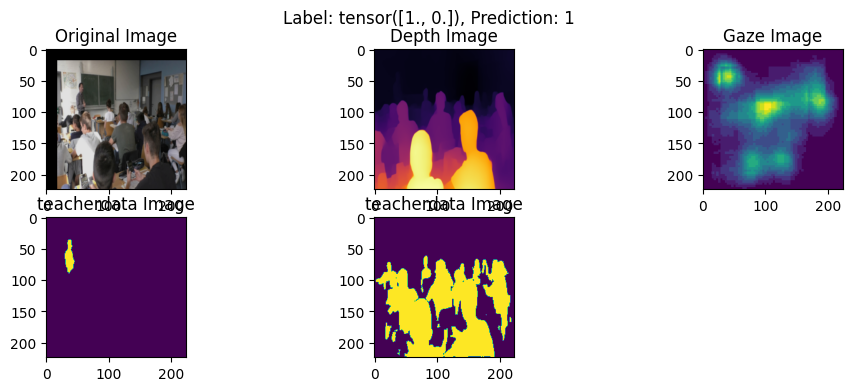

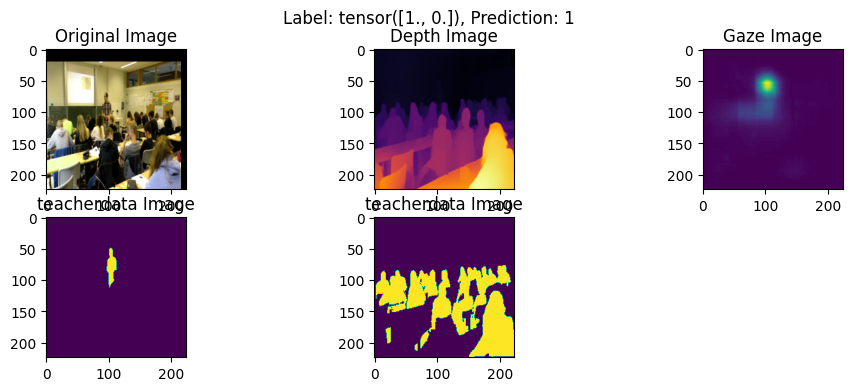

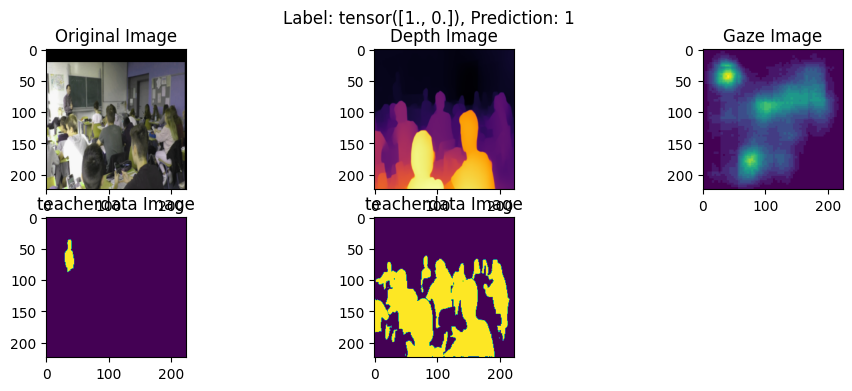

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Function to plot images
def plot_images(image, depth, gaze, teacherdata, studentdata, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(2, 3, 1)
    plt.imshow(transforms.ToPILImage()(image))
    plt.title("Original Image")
    plt.subplot(2, 3, 2)
    plt.imshow(transforms.ToPILImage()(depth))
    plt.title("Depth Image")
    plt.subplot(2, 3, 3)
    plt.imshow(transforms.ToPILImage()(gaze))
    plt.title("Gaze Image")
    plt.subplot(2, 3, 4)
    plt.imshow(transforms.ToPILImage()(teacherdata))
    plt.title("teacherdata Image")
    plt.subplot(2, 3, 5)
    plt.imshow(transforms.ToPILImage()(studentdata))
    plt.title("teacherdata Image")
    plt.suptitle(title)
    plt.show()


# Randomly pick 3 images from the validation dataset
random_indices = random.sample(range(len(valid_dataset)), 3)

for idx in random_indices:
    image, depth, gaze, label,teacherdata,studentdata = valid_dataset[idx]
    input_tensor = torch.cat([image.unsqueeze(0), depth.unsqueeze(0), gaze.unsqueeze(0),teacherdata.unsqueeze(0),studentdata.unsqueeze(0)], dim=1)
    input_tensor = input_tensor.to(device)
    
    # Get prediction
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output.data, 1)

    # Plotting
    plot_images(image, depth, gaze,teacherdata,studentdata, f"Label: {label}, Prediction: {predicted.item()}")
    